# ptt的網路分析(network analysis)
#### 近期天下的專題[輿論戰爭](https://www.cw.com.tw/article/article.action?id=5093610&fbclid=IwAR3NXtzdUBrUYBPPepMVzRXwY2tGZj6B84QzjWyPaIgjBL8QnSQjSOU6EeI#_=_)，點出在八卦或政黑有些操作的跡象，其中有些網路分析的技術，這裡嘗試重現相關分析。


### 1. import 網路分析常用的package [networkx](https://networkx.github.io/)
#### 資料取樣自ptt八卦版2018-07-15，可直接用jwliny在github的[ptt-web-crawler](https://github.com/jwlin/ptt-web-crawler)，不用自己寫爬蟲，安裝完後直接下指令(超佛!
#### python -m PttWebCrawler -b PublicServan -i 100 200
#### python crawler.py -b 看板名稱 -i 起始索引 結束索引 (設為負數則以倒數第幾頁計算) 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import operator
from collections import Counter
from IPython.display import Image 

In [2]:
path = 'Gossiping-4800-4900.json'

In [3]:
ptt_df = pd.read_json(path, encoding='utf8')

### 2. 來看看一篇文章的json長怎樣吧!

In [4]:
ptt_df.loc[0].values

array([ {'article_id': 'M.1531585982.A.2D8', 'article_title': 'Re: [新聞] 「虧雞福來爹」想「安可」分局長嗆林義豐', 'author': 'sqark912 (大野狼)', 'board': 'Gossiping', 'content': '今天如果是廟會、遶境之類的，我看鞭炮聲到半夜兩點都還吵不完 什麼?? 你說這樣擾民?很多人檢舉? 讓我們看參與者怎麼說 金衝繃 要入境隨俗，幹嘛那麼計較? 狠敢愛 神明保佑你365天，你一個晚上忍耐一下會怎樣? 將心比心 大家互相一下，這個社會就是沒有包容 咘愛喏 久久一次又不是每天我們跟神轎從晚上十一點走到早上六點，零晨天沒亮，很多虔誠信 眾拿香拜拜，大家都沒睡，還有人睡到抗議秀逗了逆 杰身自愛 當地居民也都沒在說什麼一定是外地來的才會哭啦。 求真心 你上班你最大？沒禮貌沒水準，隔天不會休假逆，我也是笑笑的啦 浪子蒼天無悔 或許有遶境過你們家 才能夠每天平平安安的出門上班下班回到家 莫忘初衷 可以戴耳機或耳塞 極速狂愛 一群酸民只會躲在螢幕後面，敢出來在講啦 社會大學 讀書讀到不知道哪裡去了，連台灣文化都不尊重， 我國小畢業都比你懂辣 ~樂晴~ 時間在走，人心在變 金好野 用行動支持， 贊成1 虔誠2 明天一起遶境3 (附上自拍一張) 不必問 陣頭不代表是壞孩子，放鞭炮不代表是壞孩子，敲鑼打鼓也不代表示壞孩子 時尚翔 有種來開我ㄚ 真的不知道在講三小 有輸沒怕 公道自在人心，啊不然你也去檢舉半夜野狗叫? (下略100則) 當地警方： 已進行多次勸導，活動和平結束。 ', 'date': 'Sun Jul 15 00:33:00 2018', 'ip': '119.14.66.205', 'message_conut': {'all': 53, 'boo': 0, 'count': 46, 'neutral': 7, 'push': 46}, 'messages': [{'push_content': '哈哈', 'push_ipdatetime': '111.254.35.228 07/15 00:33', 'push_tag': '推', 'push_userid': 'jeff0811'}, {'push_content': '虧雞沒有台灣價值，對西瓜有

### 3. 整理資料：推文作為source，發文作為target，主要是覺得推文作為主動方，觀察是否有大量互相推文的現象

In [5]:
rs_df = pd.DataFrame()

for x in ptt_df.itertuples():
    
    ##資料有點大，先取70篇文章
    if x.Index > 70:
        continue
    
    ##先把文章資料轉為DataFrame
    art = pd.DataFrame([x.articles])
    
    ##如果發文沒有人推，直接濾除
    if art.messages[0] == []:
        continue
    
    #作者 id 有中文，但推文 id只有英文，統一用 英文id 作為Key
    author_id = art.author.replace(r'\([^)]*\)', '', regex=True).values[0].replace(' ', '')
    
    reply = pd.DataFrame(art.messages.values[0])
    #push_ip_ = reply.push_ipdatetime.str.split(' ', n=1, expand=True)
    
    
    temp_df = reply[['push_userid']].copy()
    temp_df['target'] = author_id
    
    ##以發文日期作為推文的估計值，因為push_ipdatetime的ip 跟 datetime放在一起，有些只有datetime 沒有ip，好像跟RE 有關....
    temp_df['date'] = art.date[0]
    ##欄位重新命名，push_userid 改為 source
    temp_df.rename_axis({'push_userid':'source'}, axis=1, inplace=True)
    
    if rs_df.empty:
        rs_df = temp_df
    else:
        rs_df = rs_df.append(temp_df)

#### 3-1. 文章資料

In [6]:
art

,article_id,article_title,author,board,content,date,ip,message_conut,messages
0,M.1531588021.A.E12,Re: [問卦]最近好像比較少歌詞文？,Dinenger (低能兒),Gossiping,: : : 如題，本肥前陣子很喜歡在半夜偷發歌詞廢文 : : 那時也很常看到板上有很多歌詞文...,Sun Jul 15 01:06:59 2018,39.12.136.26,"{'all': 8, 'boo': 1, 'count': 3, 'neutral': 3,...","[{'push_content': ':(', 'push_ipdatetime': '22..."


#### 3-2. 回應資料

In [7]:
reply.head()

,push_content,push_ipdatetime,push_tag,push_userid
0,:(,223.136.225.207 07/15 01:07,推,a240daniel
1,嘻嘻☺ ☺ 你有被戰哦？,220.132.39.14 07/15 01:08,噓,love0504
2,人家只是發歌詞文阿,114.32.125.24 07/15 01:08,推,jhjhs33504
3,嗚嗚嗚,36.236.109.96 07/15 01:08,推,pikapikachiu
4,真ㄉ 最近肥宅好像ㄘ到炸藥一樣,223.136.225.207 07/15 01:08,→,a240daniel


## 4. 輸出檔案，給開源軟體Gephi使用

In [8]:
rs_df.head()

,source,target,date
0,jeff0811,sqark912,Sun Jul 15 00:33:00 2018
1,wyvernlee,sqark912,Sun Jul 15 00:33:00 2018
2,jeff0811,sqark912,Sun Jul 15 00:33:00 2018
3,yadogdog,sqark912,Sun Jul 15 00:33:00 2018
4,bybe,sqark912,Sun Jul 15 00:33:00 2018


In [9]:
strt_dt = str(min(pd.to_datetime(rs_df.date.unique())))
end_dt = str(max(pd.to_datetime(rs_df.date.unique())))

'資料從 {} 到 {}'.format(strt_dt, end_dt)

'資料從 2018-07-15 00:33:00 到 2018-07-15 01:06:59'

In [10]:
rs_df.date = pd.to_datetime(rs_df.date)

In [11]:
rs_df.to_csv('ptt.csv', index=False)

## 5. 把DataFrame轉為有向圖

In [11]:
G = nx.from_pandas_edgelist(rs_df, source='source', target='target', create_using=nx.DiGraph())

### 5-1. 看一下degree(in_degree + out_degree)前10名吧!
#### out-degree 外度數: 某個id留言的數量
#### in-degree 輸入度: 某個id「被」留言的數量
#### 翻譯名稱參考：http://terms.naer.edu.tw/detail/2378473/

In [12]:
#設定top幾
rnk = 20

deg_g = dict(G.degree)
top_deg_node = [ x[0] for x in sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]
sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('jacklyl', 1145),
 ('q10242', 125),
 ('zoosleep', 76),
 ('Allen0315', 72),
 ('shigenogoro', 57),
 ('On1y', 55),
 ('sqark912', 52),
 ('evachen5428', 40),
 ('LewisRong', 37),
 ('giorno78', 33),
 ('xianyao', 30),
 ('noonecare', 28),
 ('bossun851020', 27),
 ('popy8789', 26),
 ('nfish', 22),
 ('wwf0322', 21),
 ('wavelet', 19),
 ('mstory', 19),
 ('TtTt4', 19),
 ('blackkeyss', 19)]

### 5-2. 看一下pagerank前10名吧!

In [13]:
pg_rnk_g = nx.pagerank(G)
top_pg_rnk_node = [ x[0] for x in sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]

In [14]:
sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('jacklyl', 0.239874481404842),
 ('q10242', 0.15350640237335744),
 ('shigenogoro', 0.011927380169674373),
 ('zoosleep', 0.011776119498206747),
 ('Allen0315', 0.01063971722737161),
 ('Firstshadow', 0.0101207334348812),
 ('sqark912', 0.009116290453223293),
 ('kenjohn', 0.00799538801626137),
 ('On1y', 0.007272532368856508),
 ('evachen5428', 0.005810811273775679),
 ('bossun851020', 0.005272445475108469),
 ('xianyao', 0.004941223755466251),
 ('LewisRong', 0.004211753470587303),
 ('giorno78', 0.003785461044198318),
 ('nfish', 0.00360127827860056),
 ('wavelet', 0.003456403356511511),
 ('blackkeyss', 0.003452313857606779),
 ('popy8789', 0.003015242206244056),
 ('noonecare', 0.0029920334782837853),
 ('mmc109815038', 0.0029634910679674294)]

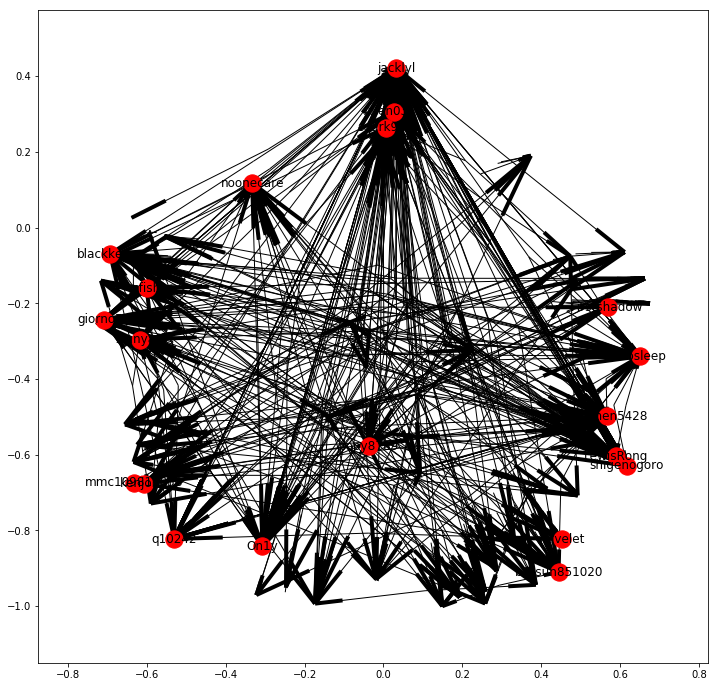

In [15]:
plt.figure(figsize=(12, 12))#nodelist
nx.draw_networkx(G, with_labels=True, nodelist=top_pg_rnk_node, labels={x:x for x in top_pg_rnk_node})
plt.show()

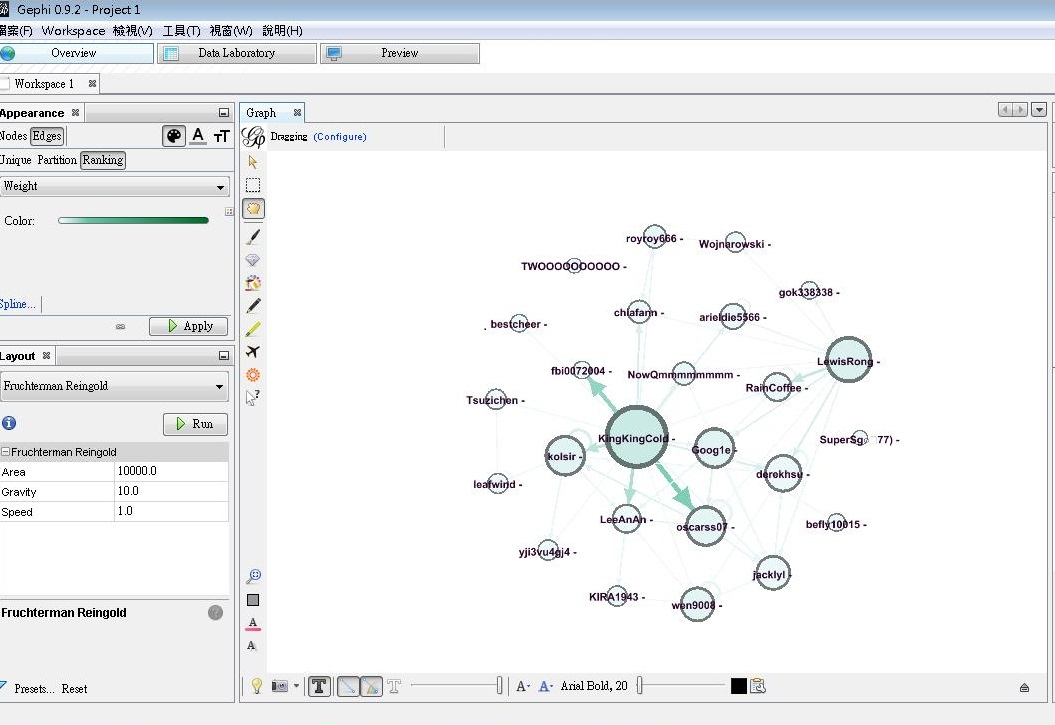

In [17]:
Image(filename = 'ptt.jpg')

# ToDo
#### 1. https://pttpedia.fandom.com/zh/wiki/KingKingCold 比對ptt名人
#### 2. 解析ip(國家) 與 回文時間
#### 3. 增加資料區間
#### 4. [add dynamic graph](https://seinecle.github.io/gephi-tutorials/generated-html/converting-a-network-with-dates-into-dynamic.html#_1_dynamic_nodes_with_a_start_date)

In [18]:
#pd.to_datetime(reply.push_ipdatetime[0]+ ' ' + str(art_year) , format='%m/%d %H:%M %Y')
#(reply.push_ipdatetime+ ' ' + str(art_year)).apply(pd.to_datetime(x, format='%m/%d %H:%M %Y'), errors='coerce')
#pitchtype[col].map(lambda x: x.replace(' %','') if type(x) == str else x)